In [64]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import matplotlib.dates as mdates
import scipy.optimize as optim
from sklearn.metrics import mean_squared_error

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
# from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
os.getcwd()

'/Users/jahnavisingh/Dropbox/Berkeley/2019-2020/PH 244/Proj4/Analysis'

In [3]:
cases = pd.read_csv('../Data/data-proj-4a.csv')
cases = cases.fillna("NA")
cases.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NA,Afghanistan,2020-01-22,0.0,0.0
1,2,NA,Afghanistan,2020-01-23,0.0,0.0
2,3,NA,Afghanistan,2020-01-24,0.0,0.0
3,4,NA,Afghanistan,2020-01-25,0.0,0.0
4,5,NA,Afghanistan,2020-01-26,0.0,0.0


In [12]:
# Convert to date time object
cases['Date'] = pd.to_datetime(cases['Date'])

In [31]:
tot_cases_by_country[:10].reset_index()

,Country_Region,ConfirmedCases
0,US,336912.0
1,Spain,131646.0
2,Italy,128948.0
3,Germany,100123.0
4,France,93772.0
5,China,82603.0
6,Iran,58226.0
7,United Kingdom,48435.0
8,Turkey,27069.0
9,Switzerland,21100.0


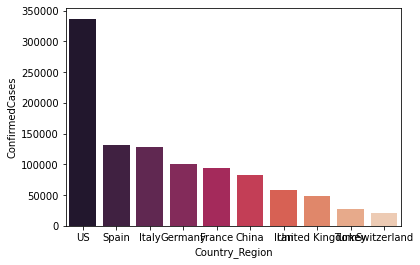

In [36]:
# from matplotlib.colors import ListedColormap

sns.barplot("Country_Region", "ConfirmedCases", data=tot_cases_by_country[:10].reset_index(), 
            palette='rocket', color="k")

  adjustable: {'box', 'datalim'}
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float or None
  anchor: 2-tuple of floats or {'C', 'SW', 'S', 'SE', ...}
  animated: bool
  aspect: {'auto', 'equal'} or num
  autoscale_on: bool
  autoscalex_on: bool
  autoscaley_on: bool
  axes_locator: Callable[[Axes, Renderer], Bbox]
  axisbelow: bool or 'line'
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  contains: callable
  facecolor: color
  fc: color
  figure: `.Figure`
  frame_on: bool
  gid: str
  in_layout: bool
  label: object
  navigate: bool
  navigate_mode: unknown
  path_effects: `.AbstractPathEffect`
  picker: None or bool or float or callable
  position: [left, bottom, width, height] or `~matplotlib.transforms.Bbox`
  prop_cycle: unknown
  rasterization_zorder: float or None
  rasterized: bool or None
  sketch_params: (scale: float, length: float, randomness: float)
  sna

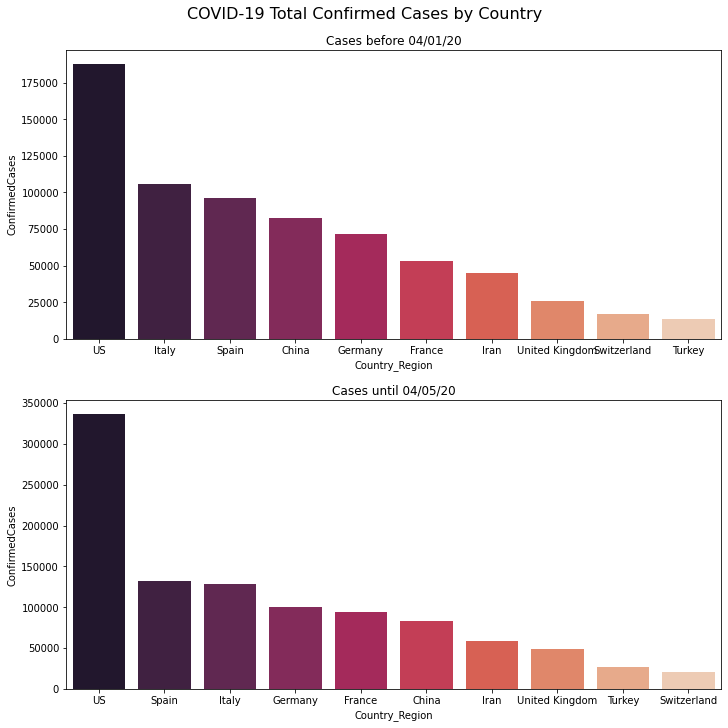

In [175]:
f, axes = plt.subplots(2, 1, figsize=(10, 10), constrained_layout=True)
# Training Distribution
train_cases = cases[cases['Date'] < '2020-04-01']
max_cases_by_state = train_cases.groupby(['Country_Region','Province_State']).max()['ConfirmedCases'].sort_values()
tot_cases_by_country = max_cases_by_state.groupby(['Country_Region']).sum().sort_values(ascending = False)
top_countries = tot_cases_by_country.index[:10]
top_countries = pd.Series(top_countries).replace({'United Kingdom': 'U.K.'})
g = sns.barplot("Country_Region", "ConfirmedCases", data=tot_cases_by_country[:10].reset_index(), 
            palette='rocket', color="k", ax=axes[0])
g.set(title="Cases before 04/01/20")
# Overall Distribution
max_cases_by_state = cases.groupby(['Country_Region','Province_State']).max()['ConfirmedCases'].sort_values()
tot_cases_by_country = max_cases_by_state.groupby(['Country_Region']).sum().sort_values(ascending = False)
top_countries = tot_cases_by_country.index[:10]
top_countries = pd.Series(top_countries).replace({'United Kingdom': 'U.K.'})
g = sns.barplot("Country_Region", "ConfirmedCases", data=tot_cases_by_country[:10].reset_index(), 
            palette='rocket', color="k", ax=axes[1])
g.set(title="Cases until 04/05/20")
# Main plot title
f.suptitle("COVID-19 Total Confirmed Cases by Country", fontsize=16)
plt.setp(axes)
f.savefig('top_10_confirmed_cases.png', dpi=f.dpi);

In [14]:
train_cases = cases[cases['Date'] < '2020-04-01']
max_cases_by_state = train_cases.groupby(['Country_Region','Province_State']).max()['ConfirmedCases'].sort_values()
tot_cases_by_country = max_cases_by_state.groupby(['Country_Region']).sum().sort_values(ascending = False)
tot_cases_by_country.head(10)

Country_Region
US                188018.0
Italy             105792.0
Spain              95923.0
China              82280.0
Germany            71808.0
France             52827.0
Iran               44605.0
United Kingdom     25481.0
Switzerland        16605.0
Turkey             13531.0
Name: ConfirmedCases, dtype: float64

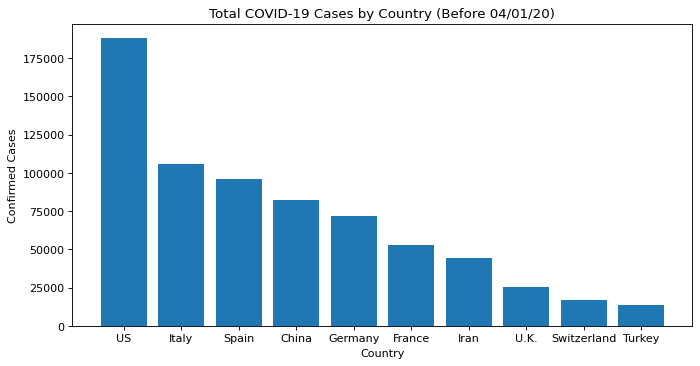

In [20]:
plt.figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
top_countries = tot_cases_by_country.index[:10]
top_countries = pd.Series(top_countries).replace({'United Kingdom': 'U.K.'})
plt.bar(top_countries, tot_cases_by_country[:10])
plt.title('Total COVID-19 Cases by Country (Before 04/01/20)')
plt.xlabel('Country')
plt.ylabel('Confirmed Cases');

In [21]:
max_cases_by_state = cases.groupby(['Country_Region','Province_State']).max()['ConfirmedCases'].sort_values()
tot_cases_by_country = max_cases_by_state.groupby(['Country_Region']).sum().sort_values(ascending = False)
tot_cases_by_country.head(10)

Country_Region
US                336912.0
Spain             131646.0
Italy             128948.0
Germany           100123.0
France             93772.0
China              82603.0
Iran               58226.0
United Kingdom     48435.0
Turkey             27069.0
Switzerland        21100.0
Name: ConfirmedCases, dtype: float64

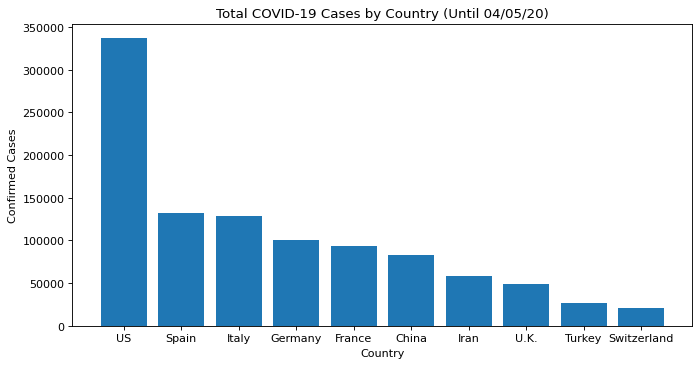

In [23]:
plt.figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
top_countries = tot_cases_by_country.index[:10]
top_countries = pd.Series(top_countries).replace({'United Kingdom': 'U.K.'})
plt.bar(top_countries, tot_cases_by_country[:10])
plt.title('Total COVID-19 Cases by Country (Until 04/05/20)')
plt.xlabel('Country')
plt.ylabel('Confirmed Cases');

In [91]:
pd.to_datetime(cases_us_per_day.index)

DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10',
               '2020-02-11', '2020-02-12', '2020-02-13', '2020-02-14',
               '2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18',
               '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22',
               '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26',
               '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01',
               '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05',
               '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09',
               '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
               '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17',
      

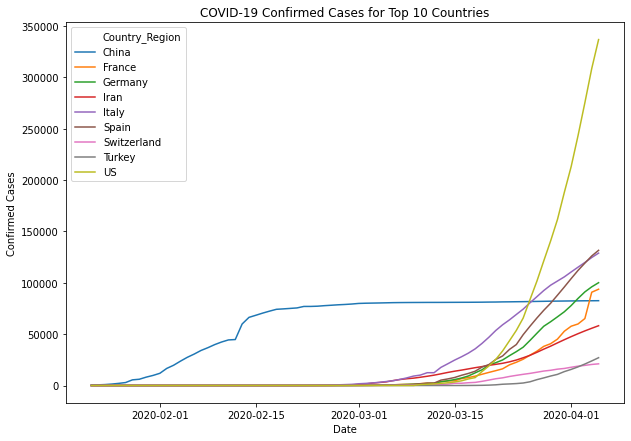

In [177]:
fig, ax = plt.subplots(figsize=(10,7))
# top_countries_daily = cases[cases['Country_Region'].isin(top_countries)].groupby(
#     ['Country_Region','Date'])[['ConfirmedCases', 'Fatalities']].sum().reset_index()
# top_countries_daily.groupby('Country_Region').plot("Date", "ConfirmedCases", label='Country_Region')
ax = sns.lineplot(x="Date", y="ConfirmedCases",
                  hue="Country_Region",
                  data=top_countries_daily)
plt.ylabel("Confirmed Cases")
plt.title("COVID-19 Confirmed Cases for Top 10 Countries")
fig.savefig('top_10_confirmed_cases_line.png', dpi=f.dpi);

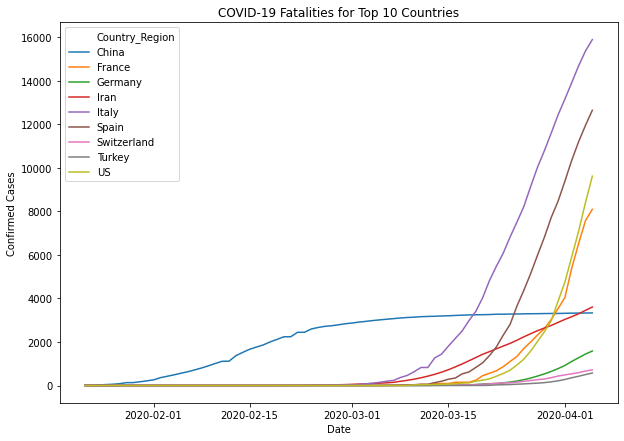

In [52]:
fig, ax = plt.subplots(figsize=(10,7))
# top_countries_daily = cases[cases['Country_Region'].isin(top_countries)].groupby(
#     ['Country_Region','Date'])[['ConfirmedCases', 'Fatalities']].sum().reset_index()
# top_countries_daily.groupby('Country_Region').plot("Date", "ConfirmedCases", label='Country_Region')
ax = sns.lineplot(x="Date", y="Fatalities",
                  hue="Country_Region",
                  data=top_countries_daily)
plt.ylabel("Confirmed Cases")
plt.title("COVID-19 Fatalities for Top 10 Countries");

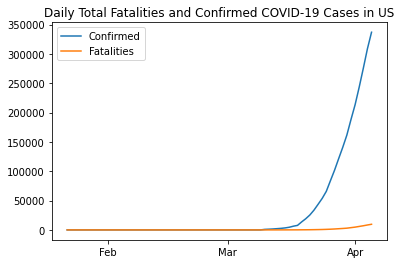

In [105]:
ax = plt.axes()
cases_us_per_day = cases[cases['Country_Region'] == 'US'].groupby('Date')[['ConfirmedCases', 'Fatalities']].sum()
cases_us_dates = pd.to_datetime(cases_us_per_day.index)
ax.plot(cases_us_dates, cases_us_per_day['ConfirmedCases'], label='Confirmed')
ax.plot(cases_us_dates, cases_us_per_day['Fatalities'], label='Fatalities')
locator = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(fmt)
plt.legend()
plt.title('Daily Total Fatalities and Confirmed COVID-19 Cases in US');

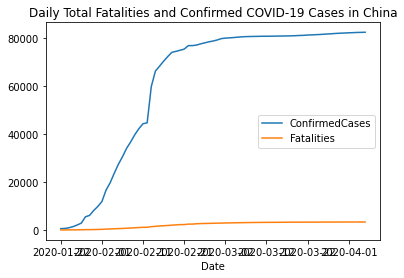

In [112]:
# ax = plt.axes()
cases_china_per_day = cases[cases['Country_Region'] == 'China'].groupby('Date')[['ConfirmedCases', 'Fatalities']].sum()
cases_china_dates = pd.to_datetime(cases_china_per_day.index)
# ax.plot(cases_china_dates, cases_china_per_day, legend=True)
cases_china_per_day.plot(legend=True, xticks=)
# ax.plot(cases_us_dates, cases_us_per_day['Fatalities'], label='Fatalities')
locator = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(fmt)
plt.legend()
plt.title('Daily Total Fatalities and Confirmed COVID-19 Cases in China');

In [56]:
top_countries_daily['Date'].min()

Timestamp('2020-01-22 00:00:00')

### Forecasting with Exponential Growth Curve 

In [53]:
def clean_country(country):
    # Get total number of cases in queried country per day
    cases_country_per_day = cases[cases['Country_Region'] == country].groupby('Date')
    cases_country_per_day = cases_country_per_day[['ConfirmedCases', 'Fatalities']].sum()
    # Only begin model with the first confirmed case
    conf_cases_country_per_day = cases_country_per_day[cases_country_per_day['ConfirmedCases'] > 0]
    conf_cases_country_per_day = conf_cases_country_per_day['ConfirmedCases']
    # Remove timestamps and replace with numerical t=0..n numbers
    conf_cases_country_per_day = conf_cases_country_per_day.reset_index()#drop=True)
    conf_cases_country_per_day = conf_cases_country_per_day.reset_index().rename(columns={'index':'t'})
    conf_cases_country_per_day['LogCases'] = np.log(conf_cases_country_per_day['ConfirmedCases'])
    return conf_cases_country_per_day

def fit_exp_country(cleaned_country_df):
    X = add_constant(cleaned_country_df['t'])
    y = cleaned_country_df['LogCases']
    
    mod = OLS(y,X)
    res = mod.fit()
    log_x0, log_b = res.params
    x0, b = np.exp(log_x0), np.exp(log_b)
    preds_func = lambda t: x0 * (b**t)
    return preds_func

def get_preds(preds_func, num_days):
    time_period = np.arange(num_days)
    preds = [preds_func(t) for t in time_period]
    return preds
    
    

In [138]:
confirmed_us_per_day = cases_us_per_day[cases_us_per_day['ConfirmedCases'] > 0]['ConfirmedCases']
confirmed_us_per_day = confirmed_us_per_day.reset_index(drop=True)
confirmed_us_per_day = confirmed_us_per_day.reset_index().rename(columns={'index':'t'})
confirmed_us_per_day['LogCases'] = np.log(confirmed_us_per_day['ConfirmedCases'])
confirmed_us_per_day[:-7], confirmed_us_per_day[-7:]

(     t  ConfirmedCases   LogCases
 0    0           892.0   6.793466
 1    1          1214.0   7.101676
 2    2          1596.0   7.375256
 3    3          2112.0   7.655391
 4    4          2658.0   7.885329
 5    5          3431.0   8.140607
 6    6          4565.0   8.426174
 7    7          6353.0   8.756682
 8    8          7715.0   8.950922
 9    9         13608.0   9.518413
 10  10         19025.0   9.853509
 11  11         25414.0  10.143055
 12  12         33663.0  10.424155
 13  13         43586.0  10.682491
 14  14         53659.0  10.890404
 15  15         65701.0  11.092869
 16  16         83759.0  11.335699
 17  17        101580.0  11.528602
 18  18        121326.0  11.706236
 19  19        140734.0  11.854627,
      t  ConfirmedCases   LogCases
 20  20        161655.0  11.993220
 21  21        188018.0  12.144293
 22  22        213214.0  12.270052
 23  23        243295.0  12.402030
 24  24        275426.0  12.526074
 25  25        308690.0  12.640093
 26  26        3369

In [139]:
X = add_constant(confirmed_us_per_day['t'])
y = confirmed_us_per_day['LogCases']

In [141]:
mod = OLS(y,X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               LogCases   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     923.2
Date:                Thu, 07 May 2020   Prob (F-statistic):           2.93e-21
Time:                        01:00:57   Log-Likelihood:                -6.3636
No. Observations:                  27   AIC:                             16.73
Df Residuals:                      25   BIC:                             19.32
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1461      0.119     59.958      0.0

In [160]:
res.params[1]

0.2389551852156343

In [144]:
log_x0, log_b = 7.1461, 0.239
x0, b = np.exp(a), np.exp(b)
us_preds = lambda t: x0 * (b**t)

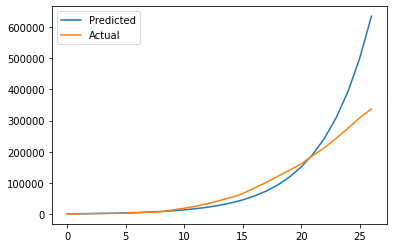

In [152]:
time_period = np.arange(27)
us_forecast = [us_preds(t) for t in time_period]
us_actual = confirmed_us_per_day['ConfirmedCases']
plt.plot(time_period, us_forecast, label='Predicted')
plt.plot(time_period, us_actual, label='Actual')
plt.legend()

In [58]:
cleaned_china

,t,Date,ConfirmedCases,LogCases
0,0,2020-01-22,548.0,6.306275
1,1,2020-01-23,643.0,6.466145
2,2,2020-01-24,920.0,6.824374
3,3,2020-01-25,1406.0,7.248504
4,4,2020-01-26,2075.0,7.637716
...,...,...,...,...
70,70,2020-04-01,82361.0,11.318867
71,71,2020-04-02,82432.0,11.319729
72,72,2020-04-03,82511.0,11.320687
73,73,2020-04-04,82543.0,11.321075


In [178]:
#Mean absolute percentage error
def mape(y2, y_pred): 
    y2, y_pred = np.array(y2), np.array(y_pred)
    return np.mean(np.abs((y2 - y_pred) / y2)) * 100

In [188]:
def plot_country(country):
    mapes = {}
    # Clean Country
    cleaned_country = clean_country(country)
    # Fit Exponential Model
    exp_func = fit_exp_country(cleaned_country)
    exp_preds = get_preds(exp_func, cleaned_country.shape[0])
    cleaned_country['ExpPredCases'] = exp_preds
    mapes['exp'] = [mean_squared_error(cleaned_country['ConfirmedCases'], exp_preds),
                    mape(cleaned_country['ConfirmedCases'], exp_preds)]
    # Fit Logistic Model
    # Randomly initialized a, b, c
    p0 = np.random.exponential(size=3)
    bounds = (0, [100000, 3, 100000000])
    x = np.array(cleaned_country['t']) + 1
    y = np.array(cleaned_country['ConfirmedCases'])
    (a,b,c), cov = optim.curve_fit(logistic, x, y, bounds=bounds, p0=p0)
    log_preds = logistic(x, a, b, c)
    cleaned_country['LogPredsCases'] = log_preds
    mapes['log'] = [mean_squared_error(cleaned_country['ConfirmedCases'], log_preds),
                    mape(cleaned_country['ConfirmedCases'], log_preds)]
    # Prophet Preds
    # The time step at which the growth is fastest
    t_fastest = np.log(a) / b
    i_fastest = logistic(t_fastest, a, b, c)
    curr_t = cleaned_country['t'].iloc[-1]
    # Figure out the growth capacity
    if (t_fastest <= curr_t):
        # Growth has been stabilized
        cap = logistic(curr_t + 10, a, b, c)
    else:
        # Still growing
        cap = logistic(i_fastest + 10, a, b, c)
    cleaned_country['cap'] = cap
    prophet_df = cleaned_country[['Date', 'ConfirmedCases', 'cap']]
    prophet_df.columns = ['ds','y','cap']
     # Train Prophet model
    m = Prophet()
    m.fit(prophet_df[['ds','y']][:-5])
    future = m.make_future_dataframe(periods=5)
    forecast = m.predict(future)
    cleaned_country['ProphetPredCases'] = forecast['yhat']
    mapes['prophet'] = [mean_squared_error(cleaned_country['ConfirmedCases'], forecast['yhat']), 
                        mape(cleaned_country['ConfirmedCases'], forecast['yhat'])]
    # Train Prophet model
    m = Prophet(growth="logistic")
    m.fit(prophet_df[['ds','y', 'cap']][:-5])
    future = m.make_future_dataframe(periods=5)
    future['cap'] = prophet_df['cap'].iloc[0]
    forecast = m.predict(future)
    cleaned_country['ProphetLogPredCases'] = forecast['yhat']
    mapes['prophet_log'] = [mean_squared_error(cleaned_country['ConfirmedCases'], forecast['yhat']), 
                        mape(cleaned_country['ConfirmedCases'], forecast['yhat'])]

    # Plot Country
    plot_country = cleaned_country[['ProphetPredCases','ProphetLogPredCases', 'LogPredsCases', 'ConfirmedCases', 'ExpPredCases']]
    fig = go.Figure([{
        'x': cleaned_country['Date'],
        'y': plot_country[col],
        'name': col
    }  for col in plot_country.columns])
    # Add Vertical Line to show training/testing cut off
    fig.update_layout(
        title="Confirmed vs. Predicted COVID-19 Cases for {}".format(country),
        xaxis_title="Date",
        yaxis_title="Cases",
    )
    return fig, mapes

In [189]:
us_fig, us_mapes = plot_country("US")
us_fig.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


In [190]:
us_mapes

{'exp': [5449202571.777247, 27.979168396539407],
 'log': [11184073.14070663, 38.51930320146899],
 'prophet': [3330874522.4331336, 366.86716490566755],
 'prophet_log': [11851046.4117473, 30.877034997482028]}

In [174]:
plot_country("Spain")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


ValueError: Invalid property specified for object of type plotly.graph_objs.Layout: 'ax'

    Valid properties:
        activeshape
            :class:`plotly.graph_objects.layout.Activeshape`
            instance or dict with compatible properties
        angularaxis
            :class:`plotly.graph_objects.layout.AngularAxis`
            instance or dict with compatible properties
        annotations
            A tuple of
            :class:`plotly.graph_objects.layout.Annotation`
            instances or dicts with compatible properties
        annotationdefaults
            When used in a template (as
            layout.template.layout.annotationdefaults), sets the
            default property values to use for elements of
            layout.annotations
        autosize
            Determines whether or not a layout width or height that
            has been left undefined by the user is initialized on
            each relayout. Note that, regardless of this attribute,
            an undefined layout width or height is always
            initialized on the first call to plot.
        bargap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        bargroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        barmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "stack", the bars are
            stacked on top of one another With "relative", the bars
            are stacked on top of one another, with negative values
            below the axis, positive values above With "group", the
            bars are plotted next to one another centered around
            the shared location. With "overlay", the bars are
            plotted over one another, you might need to an
            "opacity" to see multiple bars.
        barnorm
            Sets the normalization for bar traces on the graph.
            With "fraction", the value of each bar is divided by
            the sum of all values at that location coordinate.
            "percent" is the same but multiplied by 100 to show
            percentages.
        boxgap
            Sets the gap (in plot fraction) between boxes of
            adjacent location coordinates. Has no effect on traces
            that have "width" set.
        boxgroupgap
            Sets the gap (in plot fraction) between boxes of the
            same location coordinate. Has no effect on traces that
            have "width" set.
        boxmode
            Determines how boxes at the same location coordinate
            are displayed on the graph. If "group", the boxes are
            plotted next to one another centered around the shared
            location. If "overlay", the boxes are plotted over one
            another, you might need to set "opacity" to see them
            multiple boxes. Has no effect on traces that have
            "width" set.
        calendar
            Sets the default calendar system to use for
            interpreting and displaying dates throughout the plot.
        clickmode
            Determines the mode of single click interactions.
            "event" is the default value and emits the
            `plotly_click` event. In addition this mode emits the
            `plotly_selected` event in drag modes "lasso" and
            "select", but with no event data attached (kept for
            compatibility reasons). The "select" flag enables
            selecting single data points via click. This mode also
            supports persistent selections, meaning that pressing
            Shift while clicking, adds to / subtracts from an
            existing selection. "select" with `hovermode`: "x" can
            be confusing, consider explicitly setting `hovermode`:
            "closest" when using this feature. Selection events are
            sent accordingly as long as "event" flag is set as
            well. When the "event" flag is missing, `plotly_click`
            and `plotly_selected` events are not fired.
        coloraxis
            :class:`plotly.graph_objects.layout.Coloraxis` instance
            or dict with compatible properties
        colorscale
            :class:`plotly.graph_objects.layout.Colorscale`
            instance or dict with compatible properties
        colorway
            Sets the default trace colors.
        datarevision
            If provided, a changed value tells `Plotly.react` that
            one or more data arrays has changed. This way you can
            modify arrays in-place rather than making a complete
            new copy for an incremental change. If NOT provided,
            `Plotly.react` assumes that data arrays are being
            treated as immutable, thus any data array with a
            different identity from its predecessor contains new
            data.
        direction
            Legacy polar charts are deprecated! Please switch to
            "polar" subplots. Sets the direction corresponding to
            positive angles in legacy polar charts.
        dragmode
            Determines the mode of drag interactions. "select" and
            "lasso" apply only to scatter traces with markers or
            text. "orbit" and "turntable" apply only to 3D scenes.
        editrevision
            Controls persistence of user-driven changes in
            `editable: true` configuration, other than trace names
            and axis titles. Defaults to `layout.uirevision`.
        extendfunnelareacolors
            If `true`, the funnelarea slice colors (whether given
            by `funnelareacolorway` or inherited from `colorway`)
            will be extended to three times its original length by
            first repeating every color 20% lighter then each color
            20% darker. This is intended to reduce the likelihood
            of reusing the same color when you have many slices,
            but you can set `false` to disable. Colors provided in
            the trace, using `marker.colors`, are never extended.
        extendpiecolors
            If `true`, the pie slice colors (whether given by
            `piecolorway` or inherited from `colorway`) will be
            extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        extendsunburstcolors
            If `true`, the sunburst slice colors (whether given by
            `sunburstcolorway` or inherited from `colorway`) will
            be extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        extendtreemapcolors
            If `true`, the treemap slice colors (whether given by
            `treemapcolorway` or inherited from `colorway`) will be
            extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        font
            Sets the global font. Note that fonts used in traces
            and other layout components inherit from the global
            font.
        funnelareacolorway
            Sets the default funnelarea slice colors. Defaults to
            the main `colorway` used for trace colors. If you
            specify a new list here it can still be extended with
            lighter and darker colors, see
            `extendfunnelareacolors`.
        funnelgap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        funnelgroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        funnelmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "stack", the bars are
            stacked on top of one another With "group", the bars
            are plotted next to one another centered around the
            shared location. With "overlay", the bars are plotted
            over one another, you might need to an "opacity" to see
            multiple bars.
        geo
            :class:`plotly.graph_objects.layout.Geo` instance or
            dict with compatible properties
        grid
            :class:`plotly.graph_objects.layout.Grid` instance or
            dict with compatible properties
        height
            Sets the plot's height (in px).
        hiddenlabels
            hiddenlabels is the funnelarea & pie chart analog of
            visible:'legendonly' but it can contain many labels,
            and can simultaneously hide slices from several
            pies/funnelarea charts
        hiddenlabelssrc
            Sets the source reference on Chart Studio Cloud for
            hiddenlabels .
        hidesources
            Determines whether or not a text link citing the data
            source is placed at the bottom-right cored of the
            figure. Has only an effect only on graphs that have
            been generated via forked graphs from the Chart Studio
            Cloud (at https://chart-studio.plotly.com or on-
            premise).
        hoverdistance
            Sets the default distance (in pixels) to look for data
            to add hover labels (-1 means no cutoff, 0 means no
            looking for data). This is only a real distance for
            hovering on point-like objects, like scatter points.
            For area-like objects (bars, scatter fills, etc)
            hovering is on inside the area and off outside, but
            these objects will not supersede hover on point-like
            objects in case of conflict.
        hoverlabel
            :class:`plotly.graph_objects.layout.Hoverlabel`
            instance or dict with compatible properties
        hovermode
            Determines the mode of hover interactions. If
            "closest", a single hoverlabel will appear for the
            "closest" point within the `hoverdistance`. If "x" (or
            "y"), multiple hoverlabels will appear for multiple
            points at the "closest" x- (or y-) coordinate within
            the `hoverdistance`, with the caveat that no more than
            one hoverlabel will appear per trace. If *x unified*
            (or *y unified*), a single hoverlabel will appear
            multiple points at the closest x- (or y-) coordinate
            within the `hoverdistance` with the caveat that no more
            than one hoverlabel will appear per trace. In this
            mode, spikelines are enabled by default perpendicular
            to the specified axis. If false, hover interactions are
            disabled. If `clickmode` includes the "select" flag,
            `hovermode` defaults to "closest". If `clickmode` lacks
            the "select" flag, it defaults to "x" or "y" (depending
            on the trace's `orientation` value) for plots based on
            cartesian coordinates. For anything else the default
            value is "closest".
        images
            A tuple of :class:`plotly.graph_objects.layout.Image`
            instances or dicts with compatible properties
        imagedefaults
            When used in a template (as
            layout.template.layout.imagedefaults), sets the default
            property values to use for elements of layout.images
        legend
            :class:`plotly.graph_objects.layout.Legend` instance or
            dict with compatible properties
        mapbox
            :class:`plotly.graph_objects.layout.Mapbox` instance or
            dict with compatible properties
        margin
            :class:`plotly.graph_objects.layout.Margin` instance or
            dict with compatible properties
        meta
            Assigns extra meta information that can be used in
            various `text` attributes. Attributes such as the
            graph, axis and colorbar `title.text`, annotation
            `text` `trace.name` in legend items, `rangeselector`,
            `updatemenus` and `sliders` `label` text all support
            `meta`. One can access `meta` fields using template
            strings: `%{meta[i]}` where `i` is the index of the
            `meta` item in question. `meta` can also be an object
            for example `{key: value}` which can be accessed
            %{meta[key]}.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            meta .
        modebar
            :class:`plotly.graph_objects.layout.Modebar` instance
            or dict with compatible properties
        newshape
            :class:`plotly.graph_objects.layout.Newshape` instance
            or dict with compatible properties
        orientation
            Legacy polar charts are deprecated! Please switch to
            "polar" subplots. Rotates the entire polar by the given
            angle in legacy polar charts.
        paper_bgcolor
            Sets the background color of the paper where the graph
            is drawn.
        piecolorway
            Sets the default pie slice colors. Defaults to the main
            `colorway` used for trace colors. If you specify a new
            list here it can still be extended with lighter and
            darker colors, see `extendpiecolors`.
        plot_bgcolor
            Sets the background color of the plotting area in-
            between x and y axes.
        polar
            :class:`plotly.graph_objects.layout.Polar` instance or
            dict with compatible properties
        radialaxis
            :class:`plotly.graph_objects.layout.RadialAxis`
            instance or dict with compatible properties
        scene
            :class:`plotly.graph_objects.layout.Scene` instance or
            dict with compatible properties
        selectdirection
            When `dragmode` is set to "select", this limits the
            selection of the drag to horizontal, vertical or
            diagonal. "h" only allows horizontal selection, "v"
            only vertical, "d" only diagonal and "any" sets no
            limit.
        selectionrevision
            Controls persistence of user-driven changes in selected
            points from all traces.
        separators
            Sets the decimal and thousand separators. For example,
            *. * puts a '.' before decimals and a space between
            thousands. In English locales, dflt is ".," but other
            locales may alter this default.
        shapes
            A tuple of :class:`plotly.graph_objects.layout.Shape`
            instances or dicts with compatible properties
        shapedefaults
            When used in a template (as
            layout.template.layout.shapedefaults), sets the default
            property values to use for elements of layout.shapes
        showlegend
            Determines whether or not a legend is drawn. Default is
            `true` if there is a trace to show and any of these: a)
            Two or more traces would by default be shown in the
            legend. b) One pie trace is shown in the legend. c) One
            trace is explicitly given with `showlegend: true`.
        sliders
            A tuple of :class:`plotly.graph_objects.layout.Slider`
            instances or dicts with compatible properties
        sliderdefaults
            When used in a template (as
            layout.template.layout.sliderdefaults), sets the
            default property values to use for elements of
            layout.sliders
        spikedistance
            Sets the default distance (in pixels) to look for data
            to draw spikelines to (-1 means no cutoff, 0 means no
            looking for data). As with hoverdistance, distance does
            not apply to area-like objects. In addition, some
            objects can be hovered on but will not generate
            spikelines, such as scatter fills.
        sunburstcolorway
            Sets the default sunburst slice colors. Defaults to the
            main `colorway` used for trace colors. If you specify a
            new list here it can still be extended with lighter and
            darker colors, see `extendsunburstcolors`.
        template
            Default attributes to be applied to the plot. This
            should be a dict with format: `{'layout':
            layoutTemplate, 'data': {trace_type: [traceTemplate,
            ...], ...}}` where `layoutTemplate` is a dict matching
            the structure of `figure.layout` and `traceTemplate` is
            a dict matching the structure of the trace with type
            `trace_type` (e.g. 'scatter'). Alternatively, this may
            be specified as an instance of
            plotly.graph_objs.layout.Template.  Trace templates are
            applied cyclically to traces of each type. Container
            arrays (eg `annotations`) have special handling: An
            object ending in `defaults` (eg `annotationdefaults`)
            is applied to each array item. But if an item has a
            `templateitemname` key we look in the template array
            for an item with matching `name` and apply that
            instead. If no matching `name` is found we mark the
            item invisible. Any named template item not referenced
            is appended to the end of the array, so this can be
            used to add a watermark annotation or a logo image, for
            example. To omit one of these items on the plot, make
            an item with matching `templateitemname` and `visible:
            false`.
        ternary
            :class:`plotly.graph_objects.layout.Ternary` instance
            or dict with compatible properties
        title
            :class:`plotly.graph_objects.layout.Title` instance or
            dict with compatible properties
        titlefont
            Deprecated: Please use layout.title.font instead. Sets
            the title font. Note that the title's font used to be
            customized by the now deprecated `titlefont` attribute.
        transition
            Sets transition options used during Plotly.react
            updates.
        treemapcolorway
            Sets the default treemap slice colors. Defaults to the
            main `colorway` used for trace colors. If you specify a
            new list here it can still be extended with lighter and
            darker colors, see `extendtreemapcolors`.
        uirevision
            Used to allow user interactions with the plot to
            persist after `Plotly.react` calls that are unaware of
            these interactions. If `uirevision` is omitted, or if
            it is given and it changed from the previous
            `Plotly.react` call, the exact new figure is used. If
            `uirevision` is truthy and did NOT change, any
            attribute that has been affected by user interactions
            and did not receive a different value in the new figure
            will keep the interaction value. `layout.uirevision`
            attribute serves as the default for `uirevision`
            attributes in various sub-containers. For finer control
            you can set these sub-attributes directly. For example,
            if your app separately controls the data on the x and y
            axes you might set `xaxis.uirevision=*time*` and
            `yaxis.uirevision=*cost*`. Then if only the y data is
            changed, you can update `yaxis.uirevision=*quantity*`
            and the y axis range will reset but the x axis range
            will retain any user-driven zoom.
        uniformtext
            :class:`plotly.graph_objects.layout.Uniformtext`
            instance or dict with compatible properties
        updatemenus
            A tuple of
            :class:`plotly.graph_objects.layout.Updatemenu`
            instances or dicts with compatible properties
        updatemenudefaults
            When used in a template (as
            layout.template.layout.updatemenudefaults), sets the
            default property values to use for elements of
            layout.updatemenus
        violingap
            Sets the gap (in plot fraction) between violins of
            adjacent location coordinates. Has no effect on traces
            that have "width" set.
        violingroupgap
            Sets the gap (in plot fraction) between violins of the
            same location coordinate. Has no effect on traces that
            have "width" set.
        violinmode
            Determines how violins at the same location coordinate
            are displayed on the graph. If "group", the violins are
            plotted next to one another centered around the shared
            location. If "overlay", the violins are plotted over
            one another, you might need to set "opacity" to see
            them multiple violins. Has no effect on traces that
            have "width" set.
        waterfallgap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        waterfallgroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        waterfallmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "group", the bars are
            plotted next to one another centered around the shared
            location. With "overlay", the bars are plotted over one
            another, you might need to an "opacity" to see multiple
            bars.
        width
            Sets the plot's width (in px).
        xaxis
            :class:`plotly.graph_objects.layout.XAxis` instance or
            dict with compatible properties
        yaxis
            :class:`plotly.graph_objects.layout.YAxis` instance or
            dict with compatible properties
        

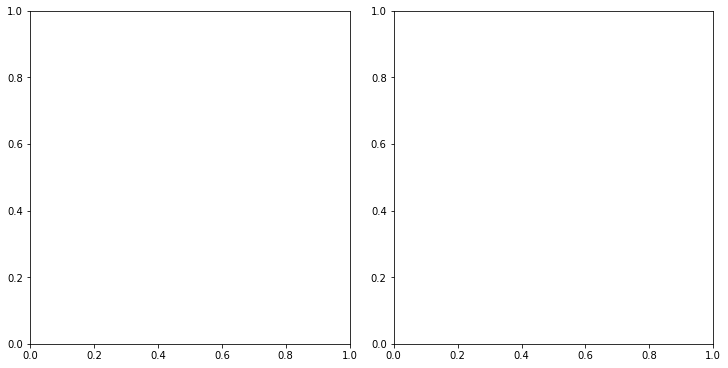

In [158]:
f, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
g = plot_country("US", axes)
f.suptitle("COVID-19 Infection and Mortality Rates for U.S. Rural and Urban Counties", 
           fontsize=16)
plt.setp(axes)

In [151]:
from plotly.subplots import make_subplots

plot_countries = ['US', 'China']

fig = make_subplots(rows=1, cols=1)

for i in range(len(plot_countries)):
    country_fig = plot_country(plot_countries[i])
    fig.add_trace(country_fig, row = 1, col = i + 1)

    fig.update_layout(height=600, width=800, title_text="Side By Side Subplots")
fig.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


ValueError: 
    Invalid element(s) received for the 'data' property of 
        Invalid elements include: [Figure({
    'data': [{'name': 'ProphetPredCases',
              'type': 'scatter',
              'x': array([datetime.datetime(2020, 3, 10, 0, 0),
                          datetime.datetime(2020, 3, 11, 0, 0),
                          datetime.datetime(2020, 3, 12, 0, 0),
                          datetime.datetime(2020, 3, 13, 0, 0),
                          datetime.datetime(2020, 3, 14, 0, 0),
                          datetime.datetime(2020, 3, 15, 0, 0),
                          datetime.datetime(2020, 3, 16, 0, 0),
                          datetime.datetime(2020, 3, 17, 0, 0),
                          datetime.datetime(2020, 3, 18, 0, 0),
                          datetime.datetime(2020, 3, 19, 0, 0),
                          datetime.datetime(2020, 3, 20, 0, 0),
                          datetime.datetime(2020, 3, 21, 0, 0),
                          datetime.datetime(2020, 3, 22, 0, 0),
                          datetime.datetime(2020, 3, 23, 0, 0),
                          datetime.datetime(2020, 3, 24, 0, 0),
                          datetime.datetime(2020, 3, 25, 0, 0),
                          datetime.datetime(2020, 3, 26, 0, 0),
                          datetime.datetime(2020, 3, 27, 0, 0),
                          datetime.datetime(2020, 3, 28, 0, 0),
                          datetime.datetime(2020, 3, 29, 0, 0),
                          datetime.datetime(2020, 3, 30, 0, 0),
                          datetime.datetime(2020, 3, 31, 0, 0),
                          datetime.datetime(2020, 4, 1, 0, 0),
                          datetime.datetime(2020, 4, 2, 0, 0),
                          datetime.datetime(2020, 4, 3, 0, 0),
                          datetime.datetime(2020, 4, 4, 0, 0),
                          datetime.datetime(2020, 4, 5, 0, 0)], dtype=object),
              'y': array([-22746.35104093, -31770.4593263 , -23659.24979909, -15741.97853513,
                           -6849.02907756,   2626.91089541,  13285.54427284,  33908.42681372,
                           24884.31854766,  32995.54239572,  40912.82799867,  49805.82478579,
                           59281.88275987,  69940.63414702,  90563.63471142,  81539.64446131,
                           89651.09215939,  97568.60161012, 106461.78929758, 115937.96744493,
                          126596.83900384, 147219.95973804, 138196.08965978, 146307.53735056,
                          154225.04680125, 163118.23448874, 172594.41263605])},
             {'name': 'ProphetLogPredCases',
              'type': 'scatter',
              'x': array([datetime.datetime(2020, 3, 10, 0, 0),
                          datetime.datetime(2020, 3, 11, 0, 0),
                          datetime.datetime(2020, 3, 12, 0, 0),
                          datetime.datetime(2020, 3, 13, 0, 0),
                          datetime.datetime(2020, 3, 14, 0, 0),
                          datetime.datetime(2020, 3, 15, 0, 0),
                          datetime.datetime(2020, 3, 16, 0, 0),
                          datetime.datetime(2020, 3, 17, 0, 0),
                          datetime.datetime(2020, 3, 18, 0, 0),
                          datetime.datetime(2020, 3, 19, 0, 0),
                          datetime.datetime(2020, 3, 20, 0, 0),
                          datetime.datetime(2020, 3, 21, 0, 0),
                          datetime.datetime(2020, 3, 22, 0, 0),
                          datetime.datetime(2020, 3, 23, 0, 0),
                          datetime.datetime(2020, 3, 24, 0, 0),
                          datetime.datetime(2020, 3, 25, 0, 0),
                          datetime.datetime(2020, 3, 26, 0, 0),
                          datetime.datetime(2020, 3, 27, 0, 0),
                          datetime.datetime(2020, 3, 28, 0, 0),
                          datetime.datetime(2020, 3, 29, 0, 0),
                          datetime.datetime(2020, 3, 30, 0, 0),
                          datetime.datetime(2020, 3, 31, 0, 0),
                          datetime.datetime(2020, 4, 1, 0, 0),
                          datetime.datetime(2020, 4, 2, 0, 0),
                          datetime.datetime(2020, 4, 3, 0, 0),
                          datetime.datetime(2020, 4, 4, 0, 0),
                          datetime.datetime(2020, 4, 5, 0, 0)], dtype=object),
              'y': array([   623.56610462,   1526.04701085,   3951.1413998 ,   5139.76874138,
                            6195.83229136,   6710.3847961 ,   7331.02074422,   9169.55421762,
                           12348.65520917,  17630.46740502,  22387.99066672,  27878.03525818,
                           33863.13880117,  41174.67738511,  51108.37548283,  63950.50343224,
                           80576.51726474,  98384.33071024, 118519.17917884, 140449.49210092,
                          164495.27314504, 191215.47761768, 219966.706557  , 250581.00511617,
                          279417.26961865, 306728.19180945, 331368.65623674])},
             {'name': 'LogPredsCases',
              'type': 'scatter',
              'x': array([datetime.datetime(2020, 3, 10, 0, 0),
                          datetime.datetime(2020, 3, 11, 0, 0),
                          datetime.datetime(2020, 3, 12, 0, 0),
                          datetime.datetime(2020, 3, 13, 0, 0),
                          datetime.datetime(2020, 3, 14, 0, 0),
                          datetime.datetime(2020, 3, 15, 0, 0),
                          datetime.datetime(2020, 3, 16, 0, 0),
                          datetime.datetime(2020, 3, 17, 0, 0),
                          datetime.datetime(2020, 3, 18, 0, 0),
                          datetime.datetime(2020, 3, 19, 0, 0),
                          datetime.datetime(2020, 3, 20, 0, 0),
                          datetime.datetime(2020, 3, 21, 0, 0),
                          datetime.datetime(2020, 3, 22, 0, 0),
                          datetime.datetime(2020, 3, 23, 0, 0),
                          datetime.datetime(2020, 3, 24, 0, 0),
                          datetime.datetime(2020, 3, 25, 0, 0),
                          datetime.datetime(2020, 3, 26, 0, 0),
                          datetime.datetime(2020, 3, 27, 0, 0),
                          datetime.datetime(2020, 3, 28, 0, 0),
                          datetime.datetime(2020, 3, 29, 0, 0),
                          datetime.datetime(2020, 3, 30, 0, 0),
                          datetime.datetime(2020, 3, 31, 0, 0),
                          datetime.datetime(2020, 4, 1, 0, 0),
                          datetime.datetime(2020, 4, 2, 0, 0),
                          datetime.datetime(2020, 4, 3, 0, 0),
                          datetime.datetime(2020, 4, 4, 0, 0),
                          datetime.datetime(2020, 4, 5, 0, 0)], dtype=object),
              'y': array([  2175.79535953,   2749.29192923,   3472.90555241,   4385.30938093,
                            5534.77197561,   6981.32116513,   8799.26706885,  11080.06380747,
                           13935.42692804,  17500.52153729,  21936.87992158,  27434.48322541,
                           34212.14375286,  42514.96856431,  52607.33100239,  64759.55670537,
                           79226.67251642,  96218.38436869, 115861.25359035, 138156.92204762,
                          162943.75085894, 189872.15245249, 218404.34331575, 247845.5769183 ,
                          277406.0701353 , 306283.24673875, 333746.80942768])},
             {'name': 'ConfirmedCases',
              'type': 'scatter',
              'x': array([datetime.datetime(2020, 3, 10, 0, 0),
                          datetime.datetime(2020, 3, 11, 0, 0),
                          datetime.datetime(2020, 3, 12, 0, 0),
                          datetime.datetime(2020, 3, 13, 0, 0),
                          datetime.datetime(2020, 3, 14, 0, 0),
                          datetime.datetime(2020, 3, 15, 0, 0),
                          datetime.datetime(2020, 3, 16, 0, 0),
                          datetime.datetime(2020, 3, 17, 0, 0),
                          datetime.datetime(2020, 3, 18, 0, 0),
                          datetime.datetime(2020, 3, 19, 0, 0),
                          datetime.datetime(2020, 3, 20, 0, 0),
                          datetime.datetime(2020, 3, 21, 0, 0),
                          datetime.datetime(2020, 3, 22, 0, 0),
                          datetime.datetime(2020, 3, 23, 0, 0),
                          datetime.datetime(2020, 3, 24, 0, 0),
                          datetime.datetime(2020, 3, 25, 0, 0),
                          datetime.datetime(2020, 3, 26, 0, 0),
                          datetime.datetime(2020, 3, 27, 0, 0),
                          datetime.datetime(2020, 3, 28, 0, 0),
                          datetime.datetime(2020, 3, 29, 0, 0),
                          datetime.datetime(2020, 3, 30, 0, 0),
                          datetime.datetime(2020, 3, 31, 0, 0),
                          datetime.datetime(2020, 4, 1, 0, 0),
                          datetime.datetime(2020, 4, 2, 0, 0),
                          datetime.datetime(2020, 4, 3, 0, 0),
                          datetime.datetime(2020, 4, 4, 0, 0),
                          datetime.datetime(2020, 4, 5, 0, 0)], dtype=object),
              'y': array([   892.,   1214.,   1596.,   2112.,   2658.,   3431.,   4565.,   6353.,
                            7715.,  13608.,  19025.,  25414.,  33663.,  43586.,  53659.,  65701.,
                           83759., 101580., 121326., 140734., 161655., 188018., 213214., 243295.,
                          275426., 308690., 336912.])},
             {'name': 'ExpPredCases',
              'type': 'scatter',
              'x': array([datetime.datetime(2020, 3, 10, 0, 0),
                          datetime.datetime(2020, 3, 11, 0, 0),
                          datetime.datetime(2020, 3, 12, 0, 0),
                          datetime.datetime(2020, 3, 13, 0, 0),
                          datetime.datetime(2020, 3, 14, 0, 0),
                          datetime.datetime(2020, 3, 15, 0, 0),
                          datetime.datetime(2020, 3, 16, 0, 0),
                          datetime.datetime(2020, 3, 17, 0, 0),
                          datetime.datetime(2020, 3, 18, 0, 0),
                          datetime.datetime(2020, 3, 19, 0, 0),
                          datetime.datetime(2020, 3, 20, 0, 0),
                          datetime.datetime(2020, 3, 21, 0, 0),
                          datetime.datetime(2020, 3, 22, 0, 0),
                          datetime.datetime(2020, 3, 23, 0, 0),
                          datetime.datetime(2020, 3, 24, 0, 0),
                          datetime.datetime(2020, 3, 25, 0, 0),
                          datetime.datetime(2020, 3, 26, 0, 0),
                          datetime.datetime(2020, 3, 27, 0, 0),
                          datetime.datetime(2020, 3, 28, 0, 0),
                          datetime.datetime(2020, 3, 29, 0, 0),
                          datetime.datetime(2020, 3, 30, 0, 0),
                          datetime.datetime(2020, 3, 31, 0, 0),
                          datetime.datetime(2020, 4, 1, 0, 0),
                          datetime.datetime(2020, 4, 2, 0, 0),
                          datetime.datetime(2020, 4, 3, 0, 0),
                          datetime.datetime(2020, 4, 4, 0, 0),
                          datetime.datetime(2020, 4, 5, 0, 0)], dtype=object),
              'y': array([  1269.1904724 ,   1611.77242593,   2046.82465673,   2599.30689221,
                            3300.91602994,   4191.90464558,   5323.39035535,   6760.2885255 ,
                            8585.03658331,  10902.32360036,  13845.09649243,  17582.18742273,
                           22328.00000613,  28354.81002946,  36008.38640209,  45727.82853898,
                           58070.75828226,  73745.31166733,  93650.76595826, 118929.13279876,
                          151030.67747005, 191797.12321335, 243567.31419823, 309311.39921086,
                          392801.23442144, 498826.78154329, 633470.91653451])}],
    'layout': {'template': '...',
               'title': {'text': 'Confirmed vs. Predicted COVID-19 Cases for US'},
               'xaxis': {'title': {'text': 'Date'}},
               'yaxis': {'title': {'text': 'Cases'}}}
})]

    The 'data' property is a tuple of trace instances
    that may be specified as:
      - A list or tuple of trace instances
        (e.g. [Scatter(...), Bar(...)])
      - A single trace instance
        (e.g. Scatter(...), Bar(...), etc.)
      - A list or tuple of dicts of string/value properties where:
        - The 'type' property specifies the trace type
            One of: ['area', 'bar', 'barpolar', 'box',
                     'candlestick', 'carpet', 'choropleth',
                     'choroplethmapbox', 'cone', 'contour',
                     'contourcarpet', 'densitymapbox', 'funnel',
                     'funnelarea', 'heatmap', 'heatmapgl',
                     'histogram', 'histogram2d',
                     'histogram2dcontour', 'image', 'indicator',
                     'isosurface', 'mesh3d', 'ohlc', 'parcats',
                     'parcoords', 'pie', 'pointcloud', 'sankey',
                     'scatter', 'scatter3d', 'scattercarpet',
                     'scattergeo', 'scattergl', 'scattermapbox',
                     'scatterpolar', 'scatterpolargl',
                     'scatterternary', 'splom', 'streamtube',
                     'sunburst', 'surface', 'table', 'treemap',
                     'violin', 'volume', 'waterfall']

        - All remaining properties are passed to the constructor of
          the specified trace type

        (e.g. [{'type': 'scatter', ...}, {'type': 'bar, ...}])

In [146]:
# Predict on US
plot_country('US').show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


In [116]:
plot_country("China")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [117]:
plot_country("Italy")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [68]:
# Predict on China
cleaned_china = clean_country('China')
china_exp_fun = fit_exp_country(cleaned_china)
china_preds = get_preds(china_exp_fun, cleaned_china.shape[0])
cleaned_china['ExpPredCases'] = china_preds
show_china = cleaned_china[['ExpPredCases', 'ConfirmedCases']]
# plotly
fig = go.Figure([{
    'x': cleaned_china['Date'],
    'y': show_china[col],
    'name': col
}  for col in show_china.columns])
fig.show()

In [44]:
cleaned_china.head()

,t,ConfirmedCases,LogCases
0,0,548.0,6.306275
1,1,643.0,6.466145
2,2,920.0,6.824374
3,3,1406.0,7.248504
4,4,2075.0,7.637716


### Forecasting with Logistic Growth

In [87]:
def logistic(t, a, b, c):
    return c / (1 + a*np.exp(-b*t))

In [88]:
# Randomly initialized a, b, c
p0 = np.random.exponential(size=3)
bounds = (0, [100000, 3, 100000000])

x = np.array(cleaned_china['t']) + 1
y = np.array(cleaned_china['ConfirmedCases'])
(a,b,c), cov = optim.curve_fit(logistic, x, y, bounds=bounds, p0=p0)
a,b,c

(62.293931485899805, 0.21941869957747484, 81371.54425917042)

In [89]:
LogPreds = logistic(x, a, b,c)
cleaned

array([ 1594.86002022,  1976.65762888,  2447.05117424,  3025.12103338,
        3733.28955591,  4597.50921556,  5647.23539022,  6915.0523594 ,
        8435.78916144, 10244.94452392, 12376.25705093, 14858.33448957,
       17710.41995191, 20937.63317479, 24526.35194743, 28440.70367222,
       32621.27338792, 36986.94726899, 41440.22929511, 45875.50067815,
       50188.83186868, 54287.46677948, 58097.20426054, 61566.55321237,
       64667.44133391, 67393.05351071, 69753.82572248, 71772.68387715,
       73480.40514127, 74911.65299832, 76101.92611716, 77085.4326043 ,
       77893.7686885 , 78555.22689514, 79094.5561212 , 79533.02019244,
       79888.63520795, 80176.49922051, 80409.15591077, 80596.95555397,
       80748.39214078, 80870.4060857 , 80968.64875334, 81047.70914036,
       81111.30533129, 81162.44443934, 81203.55510141, 81236.59652433,
       81263.14777662, 81284.48061258, 81301.61867873, 81315.38552855,
       81326.44348391, 81335.32503836, 81342.45820164, 81348.18693364,
      

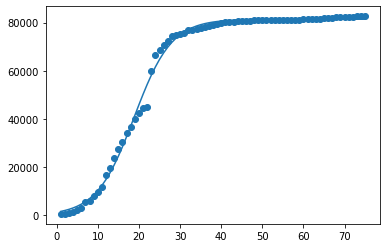

In [90]:
plt.scatter(x, y)
plt.plot(x,logistic(x, a, b,c))

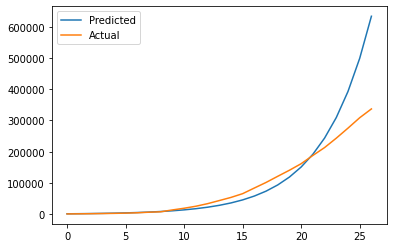

In [105]:
# Predict on US
cleaned_us = clean_country('US')
us_exp_fun = fit_exp_country(cleaned_us)
us_preds = get_preds(us_exp_fun, cleaned_us.shape[0])
time_period = np.arange(cleaned_us.shape[0])
us_actual = cleaned_us['ConfirmedCases']
plt.plot(time_period, us_preds, label='Predicted')
plt.plot(time_period, us_actual, label='Actual')
plt.legend()

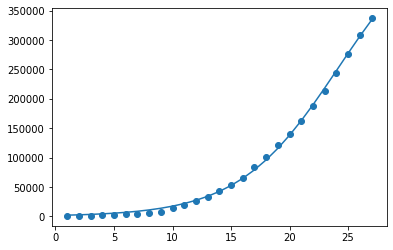

In [106]:
# Randomly initialized a, b, c
p0 = np.random.exponential(size=3)
bounds = (0, [100000, 3, 100000000])

x = np.array(cleaned_us['t']) + 1
y = np.array(cleaned_us['ConfirmedCases'])
(a,b,c), cov = optim.curve_fit(logistic, x, y, bounds=bounds, p0=p0)
plt.scatter(x, y)
plt.plot(x,logistic(x, a, b,c))

In [107]:
# The time step at which the growth is fastest
t_fastest = np.log(a) / b
i_fastest = logistic(t_fastest, a, b, c)
t_fastest, i_fastest

(24.146982423321646, 252202.47253922737)

In [108]:
curr_t = cleaned_us['t'].iloc[-1]
if (t_fastest <= curr_t):
    # Growth has been stabilized
    cap = logistic(curr_t + 10, a, b, c)
else:
    # Still growing
    cap = logistic(i_fastest + 10, a, b, c)
cleaned_us['cap'] = cap

In [109]:
cleaned_us.head()

,t,Date,ConfirmedCases,LogCases,cap
0,0,2020-03-10,892.0,6.793466,475121.3938
1,1,2020-03-11,1214.0,7.101676,475121.3938
2,2,2020-03-12,1596.0,7.375256,475121.3938
3,3,2020-03-13,2112.0,7.655391,475121.3938
4,4,2020-03-14,2658.0,7.885329,475121.3938


In [110]:
cleaned_us.columns = ['t','ds','y','log', 'cap']
cleaned_us[['ds','y', 'cap']].head()

,ds,y,cap
0,2020-03-10,892.0,475121.3938
1,2020-03-11,1214.0,475121.3938
2,2020-03-12,1596.0,475121.3938
3,2020-03-13,2112.0,475121.3938
4,2020-03-14,2658.0,475121.3938


In [111]:
m = Prophet(growth="logistic")
m.fit(cleaned_us[['ds','y', 'cap']][:-5])
future = m.make_future_dataframe(periods=5)
future['cap'] = cleaned_us['cap'].iloc[0]
forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


In [113]:
forecast['yhat']

0        623.565362
1       1526.047392
2       3951.141949
3       5139.769505
4       6195.833158
5       6710.385546
6       7331.021038
7       9169.553839
8      12348.655955
9      17630.468305
10     22387.991750
11     27878.036398
12     33863.139775
13     41174.677743
14     51108.374863
15     63950.503476
16     80576.516877
17     98384.329898
18    118519.178179
19    140449.491391
20    164495.273506
21    191215.480392
22    219966.715479
23    250581.021369
24    279417.295376
25    306728.228821
26    331368.705671
Name: yhat, dtype: float64

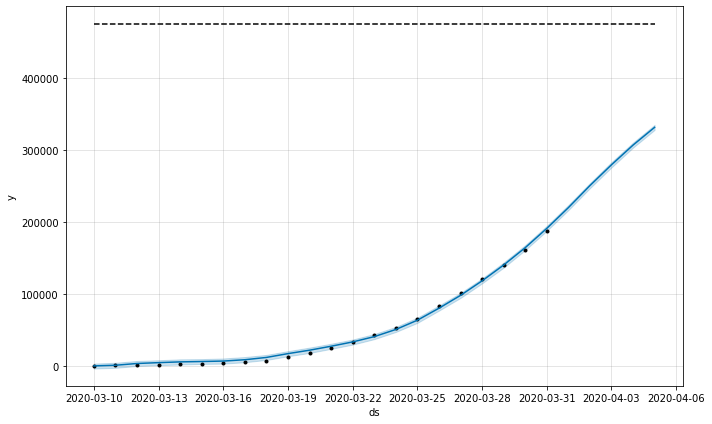

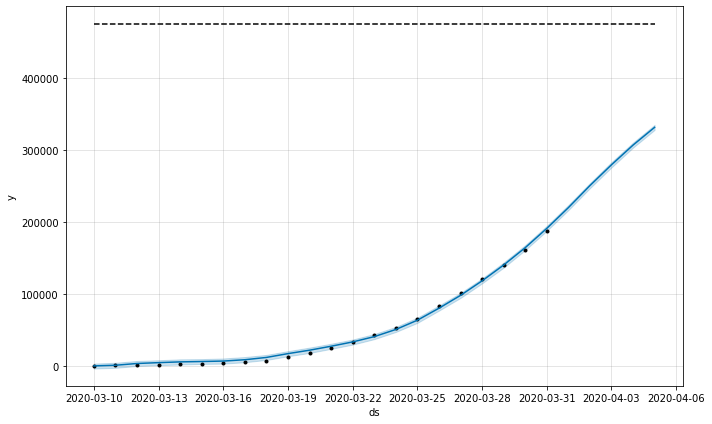

In [95]:
m.plot(forecast)

In [97]:
forecast.tail()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
22,2020-04-01,220918.517599,475121.461553,216566.047170,223710.774350,220918.446922,220918.580587,-951.787532,-951.787532,-951.787532,-951.787532,-951.787532,-951.787532,0.0,0.0,0.0,219966.730067
23,2020-04-02,249785.937762,475121.461553,246964.656205,254042.164795,249785.681436,249786.161189,795.104458,795.104458,795.104458,795.104458,795.104458,795.104458,0.0,0.0,0.0,250581.042220
24,2020-04-03,278295.844513,475121.461553,275785.494608,283152.722204,278295.342679,278296.273715,1121.478000,1121.478000,1121.478000,1121.478000,1121.478000,1121.478000,0.0,0.0,0.0,279417.322513
25,2020-04-04,305645.996598,475121.461553,303227.680090,310273.457688,305645.248342,305646.684177,1082.265581,1082.265581,1082.265581,1082.265581,1082.265581,1082.265581,0.0,0.0,0.0,306728.262179
26,2020-04-05,331161.623902,475121.461553,327777.142134,334862.216192,331160.673067,331162.519914,207.120984,207.120984,207.120984,207.120984,207.120984,207.120984,0.0,0.0,0.0,331368.744886


In [119]:
cleaned_us.tail()

,t,ds,y,log,cap
22,22,2020-04-01,213214.0,12.270052,475121.461553
23,23,2020-04-02,243295.0,12.402030,475121.461553
24,24,2020-04-03,275426.0,12.526074,475121.461553
25,25,2020-04-04,308690.0,12.640093,475121.461553
26,26,2020-04-05,336912.0,12.727577,475121.461553


In [117]:
dts_pred = future.tail()['ds']
cleaned_us['ds'] = pd.to_datetime(cleaned_us['ds'])
y_true = cleaned_us[cleaned_us['ds'].isin(dts_pred)]['y']
y_pred = forecast[forecast['ds'].isin(dts_pred)]['yhat']
mean_squared_error(y_true, y_pred)

29838504.506120004

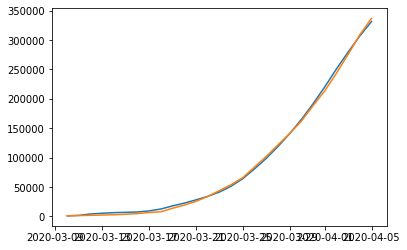

In [118]:
plt.plot(forecast['ds'], forecast['yhat'])
plt.plot(cleaned_us['ds'], cleaned_us['y'])

### Forecasting Predictions using Prophet

In [9]:
confirmed_tot = cases.groupby('Date').sum()['ConfirmedCases'].reset_index()
confirmed_tot.columns = ['ds','y']
confirmed_tot['ds'] = pd.to_datetime(confirmed_tot['ds'])
confirmed_tot.head()

,ds,y
0,2020-01-22,554.0
1,2020-01-23,653.0
2,2020-01-24,939.0
3,2020-01-25,1432.0
4,2020-01-26,2113.0


In [37]:
confirmed_tot[:-5]#, confirmed_tot[-5:]

,ds,y
0,2020-01-22,554.0
1,2020-01-23,653.0
2,2020-01-24,939.0
3,2020-01-25,1432.0
4,2020-01-26,2113.0
...,...,...
65,2020-03-27,593201.0
66,2020-03-28,660541.0
67,2020-03-29,719952.0
68,2020-03-30,782200.0


In [38]:
m = Prophet(interval_width=0.95, growth="logistic")
m.fit(confirmed_tot[:-5])
future = m.make_future_dataframe(periods=5)
future_confirmed = future.copy() # for non-baseline predictions later on
future.tail()

ValueError: Capacities must be supplied for logistic growth in column "cap"

In [22]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
75,2020-04-06,1.256380e+06,1.222333e+06,1.294260e+06
76,2020-04-07,1.318604e+06,1.285130e+06,1.356483e+06
77,2020-04-08,1.382782e+06,1.346163e+06,1.418334e+06
78,2020-04-09,1.449115e+06,1.409822e+06,1.487868e+06
79,2020-04-10,1.515682e+06,1.474132e+06,1.557345e+06


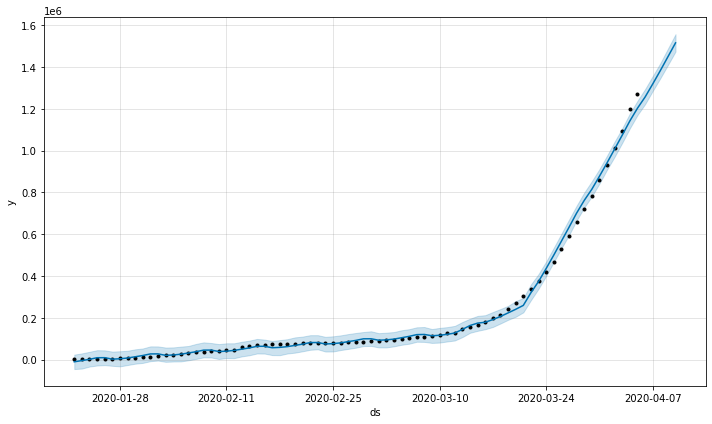

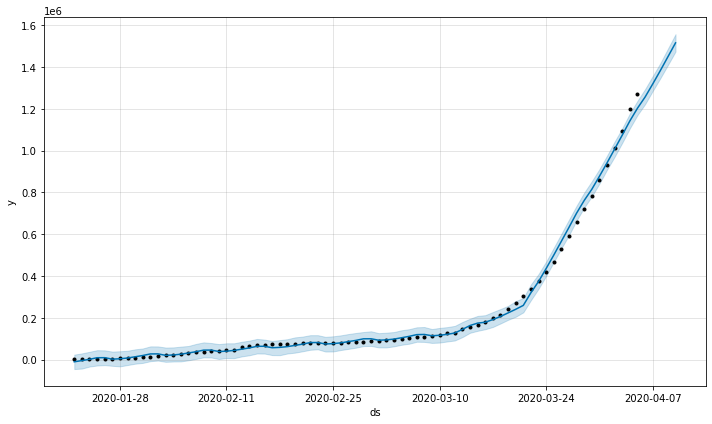

In [23]:
m.plot(forecast)

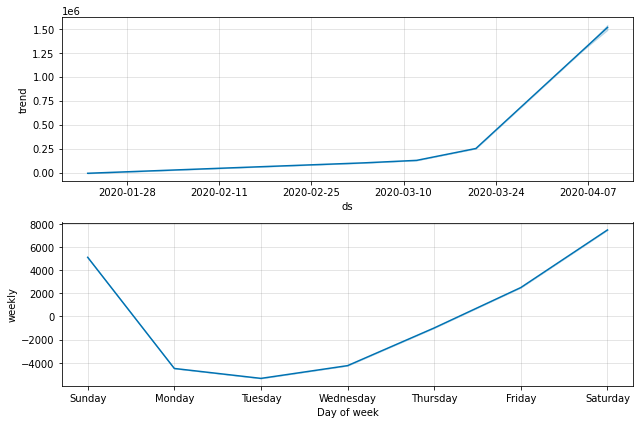

In [24]:
m.plot_components(forecast);

In [35]:
cv_res = cross_validation(m, initial='60 days', horizon='5 days')
cv_res

INFO:fbprophet:Making 4 forecasts with cutoffs between 2020-03-23 12:00:00 and 2020-03-31 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-03-24,328919.948638,303035.246639,3.554538e+05,417951.0,2020-03-23 12:00:00
1,2020-03-25,344005.461279,319778.347263,3.690498e+05,467563.0,2020-03-23 12:00:00
2,2020-03-26,360315.843482,334794.739135,3.856303e+05,529501.0,2020-03-23 12:00:00
3,2020-03-27,377635.577830,352403.029250,4.037001e+05,593201.0,2020-03-23 12:00:00
4,2020-03-28,394284.301100,367663.716085,4.213851e+05,660541.0,2020-03-23 12:00:00
5,2020-03-27,477959.507433,446565.218051,5.057926e+05,593201.0,2020-03-26 00:00:00
6,2020-03-28,502122.382081,472679.581308,5.322325e+05,660541.0,2020-03-26 00:00:00
7,2020-03-29,526656.229385,498018.411128,5.562157e+05,719952.0,2020-03-26 00:00:00
8,2020-03-30,552064.572425,519059.397362,5.835316e+05,782200.0,2020-03-26 00:00:00
9,2020-03-31,578085.073601,546661.091043,6.093264e+05,857320.0,2020-03-26 00:00:00


In [36]:
performance_metrics(cv_res)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,0 days 12:00:00,1.247041e+10,111671.006715,109734.961770,0.197098,0.197098,0.0
1,1 days 00:00:00,1.333065e+10,115458.420027,115458.216623,0.159164,0.159164,0.0
2,1 days 12:00:00,2.088985e+10,144533.222312,143193.201940,0.236213,0.236213,0.0
3,2 days 00:00:00,2.404551e+10,155066.159641,155029.110510,0.194764,0.194764,0.0
4,2 days 12:00:00,3.583551e+10,189302.691253,188331.915838,0.280763,0.280763,0.0
5,3 days 00:00:00,3.649126e+10,191026.855259,191013.217822,0.220362,0.220362,0.0
6,3 days 12:00:00,5.451187e+10,233477.762579,232837.978870,0.315814,0.315814,0.0
7,4 days 00:00:00,5.644254e+10,237576.382968,237463.343267,0.249341,0.249341,0.0
8,4 days 12:00:00,7.930464e+10,281610.793895,281213.332456,0.347732,0.347732,0.0
9,5 days 00:00:00,7.666887e+10,276891.441514,276881.439397,0.270771,0.270771,0.0


In [33]:
prof_df = forecast[forecast['Country_Region'] == 'China'][['Date', 'ConfirmedCases']][:-10]
prof_df = prof_df.rename(columns={'Date':'ds', 'ConfirmedCases':'y'})
prof_df.head()

,ds,y
4050,2020-01-22,1.0
4051,2020-01-23,9.0
4052,2020-01-24,15.0
4053,2020-01-25,39.0
4054,2020-01-26,60.0


In [36]:
prof_df

,ds,y
4050,2020-01-22,1.0
4051,2020-01-23,9.0
4052,2020-01-24,15.0
4053,2020-01-25,39.0
4054,2020-01-26,60.0
...,...,...
6510,2020-03-22,1238.0
6511,2020-03-23,1238.0
6512,2020-03-24,1240.0
6513,2020-03-25,1241.0


In [34]:
m = Prophet()
m.fit(prof_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [35]:
future = m.make_future_dataframe(periods=10)
future.tail()

,ds
2470,2020-04-11
2471,2020-04-12
2472,2020-04-13
2473,2020-04-14
2474,2020-04-15


In [40]:
forecast_preds = m.predict(future)
forecast_preds[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2470,2020-04-11,2808.579969,-9657.704459,15291.737757
2471,2020-04-12,2817.828799,-9791.951561,15002.187816
2472,2020-04-13,2839.152673,-9341.299210,14435.072366
2473,2020-04-14,2850.438221,-9131.168468,14976.755572
2474,2020-04-15,2839.230209,-9070.354582,15163.356183


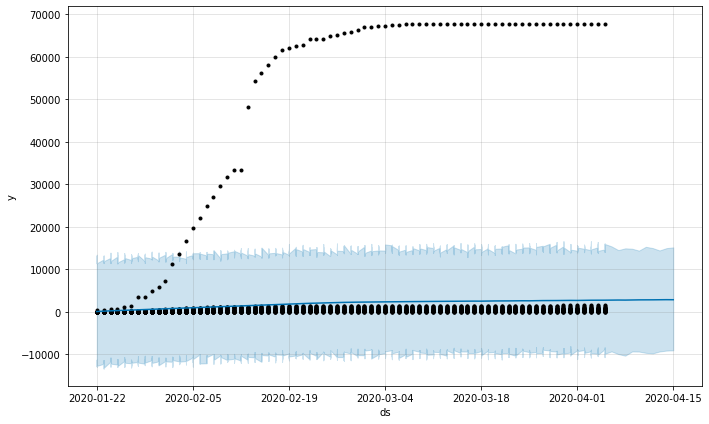

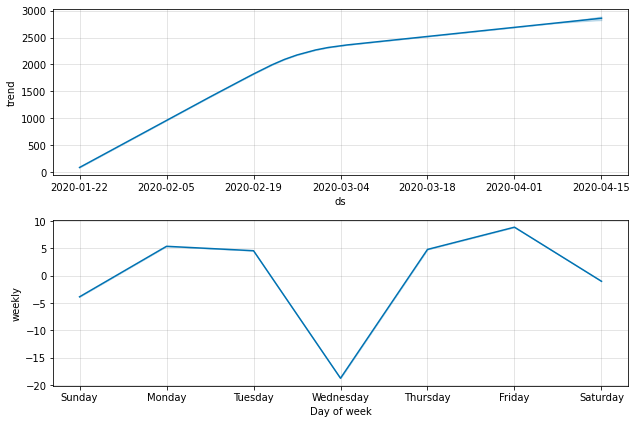

In [43]:
fig1 = m.plot(forecast_preds)
fig2 = m.plot_components(forecast_preds)

In [11]:
forecast['Country_Region'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guinea', 'Guine

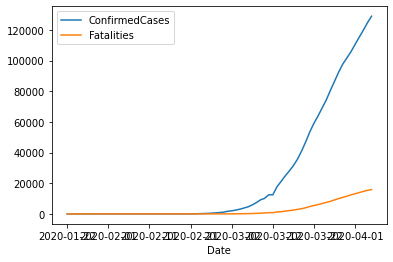

In [8]:
grouped_forecast = forecast[forecast['Country_Region'] == 'Italy'].groupby('Date')
grouped_forecast[['ConfirmedCases', 'Fatalities']].mean().plot()

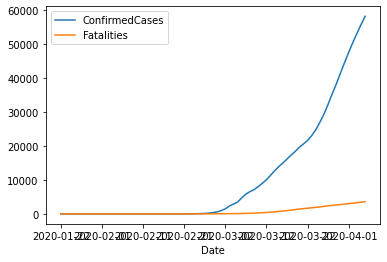

In [7]:
grouped_forecast = forecast[forecast['Country_Region'] == 'Iran'].groupby('Date')
grouped_forecast[['ConfirmedCases', 'Fatalities']].mean().plot()

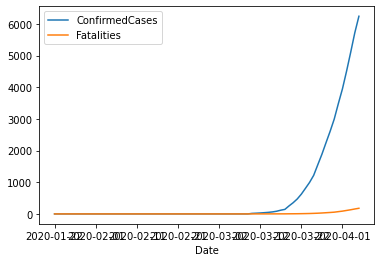

In [5]:
grouped_forecast = forecast[forecast['Country_Region'] == 'US'].groupby('Date')
grouped_forecast[['ConfirmedCases', 'Fatalities']].mean().plot()

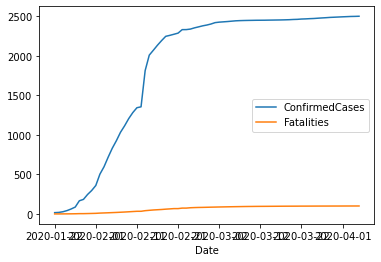

In [4]:
grouped_forecast = forecast[forecast['Country_Region'] == 'China'].groupby('Date')
grouped_forecast[['ConfirmedCases', 'Fatalities']].mean().plot()

In [ ]:
plt.plot(forecast['Date'], forecast['ConfirmedCases'], group)